<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
     <img style="float: right; padding-right: 10px" width="100" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>
     </div>

**Clemson University**<br>
**Instructor(s):** Aaron Masino <br>

## Lab 9B: Transformers

This lab will introduce you to the creation, training, and evaluation of Transformer models using the [PyTorch](https://pytorch.org/) and [PyTorch Lightning](https://lightning.ai/pytorch-lightning) libraries. PyTorch contains core capabilities related to the development of deep learning models. PyTorch Lightning provides functionally that abstracts much of the process of training and evaluating deep learning models created with PyTorch.

By the end of this lab, you should be able to:
- Apply SpaCy libraries to tokenize input text sequences 
- Apply PyTorch Embedding modules to manage token to embedding transformations
- Evaluate transformer layer output dimensions using PyTorch TransformerEncoderLayer and TransformerEncoder classes
- Apply PyTorch TransformerEncoderLayer and TransformerEncoder and Transformer concepts to build text classification models

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch import seed_everything
import lightning.pytorch.trainer as trainer
import torchmetrics as TM
import torchmetrics as TM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English 

In [2]:
def create_data_directory(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

dir_dataroot = os.path.join("..", "data")
create_data_directory(dir_dataroot)

dir_lightning = os.path.join("..", "lightning")
create_data_directory(dir_lightning)

SEED = 123456

In [3]:
# Apple MPS does not support float64, so set default tensor type to float32
if torch.backends.mps.is_available():
    torch.set_default_dtype(torch.float32)
    accelerator = "mps"
elif torch.cuda.is_available():
    accelerator = "cuda"
print(accelerator)

mps


# Part 1 Text Classification with Transformers

## Preparing Text Input for Use in PyTorch

We'll be working with the AGNews dataset. The data contains input text samples which are the text for a new article title and description. The labels for each sample refer to one of four categories: _World_, _Sports_, _Business_, _Sci/Tech_. Our goal is to develop a model using transformers to classify the input samples.

Let's beging by examining samples in this dataset.

In [4]:
df_ag_news_train = pd.read_csv(os.path.join(dir_dataroot, "ag-news-train.csv")).rename(columns={"Class Index": "label", "Title": "title"})
# the dataset labels are 1-indexed, so we need to convert them to 0-indexed
df_ag_news_train.label = df_ag_news_train.label - 1
display(df_ag_news_train.head())

df_ag_news_test = pd.read_csv(os.path.join(dir_dataroot, "ag-news-test.csv")).rename(columns={"Class Index": "label", "Title": "title"})
# the dataset labels are 1-indexed, so we need to convert them to 0-indexed
df_ag_news_test.label = df_ag_news_test.label - 1
display(df_ag_news_test.head())

,label,title,Description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


,label,title,Description
0,2,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,3,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,3,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,3,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,3,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In order to use this dataset to train a classifcation model, we will need to convert the text input to a numerical representation. To do that, we need to:
1. Construct a vocabulary representing all of the unique tokens in the text and assign a unique integer to each token
2. Construct a function to convert a text sample to a list of token indices
3. Determine the maximum length sample
4. Develop data handlers (PyTorch DataSet, DataLoader, and PyTorch Lightning DataModule) for model training and predictions

For simplicity, we will only use the article title.

Let's first build the vocabulary. This requires tokenizing every sample in the training data and identifying the unique tokens.

In [5]:
class SimpleVocab:
    def __init__(self, iter, min_freq=1, tokenizer=None, unk_idx = 0, pad_idx=1):
        self.itos = ['<unk>', '<pad>']
        self.stoi = {'<unk>': unk_idx, '<pad>': pad_idx}
        self.tokenizer = tokenizer
        self.unk_idx = unk_idx
        self.pad_idx = pad_idx
        for text in iter:
            for token in self.tokenizer(text):
                token = token.text.lower()
                if token not in self.stoi:
                    self.stoi[token] = len(self.itos)
                    self.itos.append(token)

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi.get(token, self.unk_idx)
    
    def to_index_list(self, text, min_tokens=0):
        """
        Convert a string to a list of indices.
        Args:
            text (str): The string to convert.
            min_tokens (int): The minimum number of tokens to return. If the string has fewer tokens, pad with <pad> token. Ignored if <=0
        Returns:
            list: A list of indices.
        """
        if min_tokens > 0:
            tokens = [token.text.lower() for token in self.tokenizer(text)]
            if len(tokens) < min_tokens:
                tokens += ['<pad>'] * (min_tokens - len(tokens))
        else:
            tokens = [token.text.lower() for token in self.tokenizer(text)]
        return [self.stoi.get(token, self.unk_idx) for token in tokens]

    def to_index_tensor(self, text, min_tokens=0):
        indices = self.to_index_list(text, min_tokens)
        return torch.tensor(indices, dtype=torch.int32)
    
# use spacy tokenizer
ag_news_vocab = SimpleVocab(df_ag_news_train['title'], tokenizer=Tokenizer(English().vocab))
print(f"Vocabulary size: {len(ag_news_vocab)}")


Vocabulary size: 55459


The `vocab` object provides a mapping from tokens to integer indices. Given a set of tokens, it can be used to convert them to a list of indices. Let's see an example. It also supports converting the list to a PyTorch tensor which we will need for our models.

In [6]:
sample = df_ag_news_train['title'].iloc[3450]
print(sample)
print([t.text.lower() for t in ag_news_vocab.tokenizer(sample)])
print(ag_news_vocab.to_index_list(sample))
print(ag_news_vocab.to_index_tensor(sample))

Durazo Leads Athletics by Orioles 5-4 (AP)
['durazo', 'leads', 'athletics', 'by', 'orioles', '5-4', '(ap)']
[6575, 1201, 3421, 426, 3470, 4890, 52]
tensor([6575, 1201, 3421,  426, 3470, 4890,   52], dtype=torch.int32)


Now that we have a vocabulary, it will be convenient to create a Data Set class from our Pandas DataFrame which we will need for our Data Modules.

In [7]:
class PandasTextDataset(torch.utils.data.Dataset):
    def __init__(self, df, text_col='text', label_col='label'):
        super().__init__()
        self.df = df
        self.length = len(df.index)

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.df.iloc[idx]['title'], self.df.iloc[idx]['label'].item()
    
ag_train_dataset = PandasTextDataset(df_ag_news_train, text_col='title', label_col='label')

Let's find the maximum length text in the dataset (i.e., the sample with the most tokens). We will need to know this when we build our Transformer model as it will expect every input sample in the mini-batch to be of the same length (remember, PyTorch Tensors require the same size for every element in the Tensor). This means that for any sample that has fewer tokens than the longest sample, we will need to add `<pad>` tokens. 

In [8]:
max_tokens = 0
for text, label in ag_train_dataset:
    l = len(ag_news_vocab.to_index_list(text))
    if l > max_tokens:
        max_tokens = l
print("Longest training text sample:", max_tokens)

Longest training text sample: 19


We can use this value to set samples to be of the same length which will be necessary for batch training

In [9]:
text, label = next(iter(ag_train_dataset))
print(ag_news_vocab.to_index_list(text, max_tokens))
print(ag_news_vocab.to_index_tensor(text, max_tokens))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1], dtype=torch.int32)


Now we have the pieces we need to build our custom DataModule.

In [10]:
class TextDataModule(L.LightningDataModule):
    def __init__(self, train_dataset, test_dataset, vocab, val_fraction = 0.1, 
                 batch_size=16, embedding_dim=64, max_input_length=512,
                 class_name_map=None, accelerator='cpu'):
        super().__init__()
        self.batch_size = batch_size
        self.val_fraction = val_fraction
        self.embedding_dim = embedding_dim
        self.max_tokens = None
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.vocab = vocab
        self.max_input_length = max_input_length
        self.class_name_map = class_name_map

    def max_tokens_in(self, dataset):
        max_tokens = 0
        for text, _ in dataset:
            l = len(self.vocab.to_index_list(text))
            if l > max_tokens:
                max_tokens = l
        return max_tokens
    
    def max_sample_length(self):
        return min(self.max_input_length, self.max_tokens)
    
    def collate_batch(self, batch):
        device = accelerator
        max_input = min(self.max_tokens, self.max_input_length)
        text_batch = torch.zeros((len(batch), max_input), dtype=torch.int32)
        labels_batch = torch.zeros((len(batch)), dtype=torch.int32)
        cnt = 0
        for text, label in batch:
            labels_batch[cnt] = label
            text_tensor = self.vocab.to_index_tensor(text, self.max_tokens)
            text_batch[cnt] = text_tensor[:max_input]
            cnt += 1
        return text_batch.to(device), labels_batch.to(device) 

    def setup(self, stage=None):
        dataset = self.train_dataset
        self.max_tokens = self.max_tokens_in(dataset)
        n_data = len(dataset)
        n_train = int((1-self.val_fraction) * n_data)
        n_val = n_data - n_train
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

        self._train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_batch)
        self._val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, collate_fn=self.collate_batch)
        self._test_dataloader = DataLoader(self.test_dataset, batch_size=self.batch_size, collate_fn=self.collate_batch)

    def train_dataloader(self):
        return self._train_dataloader

    def test_dataloader(self):
        return self._test_dataloader
    
    def val_dataloader(self):
        return self._val_dataloader

Let's make sure our DataModule works as expected. 

In [11]:
# load the AG_NEWS dataset
seed_everything(SEED)
dm = TextDataModule(PandasTextDataset(df_ag_news_train, text_col='title', label_col='label'),
                    PandasTextDataset(df_ag_news_test, text_col='title', label_col='label'), 
                    SimpleVocab(df_ag_news_train['title'], tokenizer=Tokenizer(English().vocab)), 
                    val_fraction = 0.1, batch_size=16, embedding_dim=64, max_input_length=256,
                    class_name_map={0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}, accelerator=accelerator)
dm.setup()

Seed set to 123456


Let's see how many mini-batches are in each sample. Remember, each mini-batch has multiple samples (determined by the `batch_size` argument to the `TextDataModule`) class.

In [12]:
print(len(dm.train_dataloader()))
print(len(dm.val_dataloader()))
print(len(dm.test_dataloader()))

6750
750
475


We can now use the dataloaders to get individual samples by access the dataset directly.

In [13]:
for idx in range(5):
    print(dm.train_dataloader().dataset[idx])

('France Was Ready to Send Troops to Iraq, Book Says', 0)
('Crunch vote for new EU Commission', 0)
('New US Study Faults Automakers for Whiplash', 3)
('Blockbuster move: biggest video and game renter eliminating late &lt;b&gt;...&lt;/b&gt;', 2)
('Levet, Jimenez Share Lead at BMW Open (AP)', 1)


We can also get a minibatch. Importantly, the batch is __not__ a collection of words. Rather, when the DataModule loads a batch from the DataSet, it passes the samples provided by the DataSet through its `collate_batch` function which tokenizes the text and converts it to vocabulary indices. It also converts the list of indices to a Tensor. The mini-batch is now ready to be used in model training and prediction.

In [14]:
print(next(iter(dm.train_dataloader())))

(tensor([[ 2808,  1004,    31,    93,    84,  3077,  3904,  3021,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1],
        [35831,  3920,   501,    31,   154,   155,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1],
        [20866, 10992, 27331, 52871,    52,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1],
        [ 6680,  3958, 37908,  1770,  2640,   415, 24152,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1],
        [ 2317, 11367,  4885,    16,    29,   331,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1],
        [42208, 19136, 42209,    49, 42001, 17904,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1],
        [ 3181,  3205,   323,  3917,   480, 42993,   453,  8015,     1,     1,
        

We will ultimately need to represent each token as a vector rather than an index value. We could use 1-hot embeddings but these are sub-optimal because they are sparse (we would need each token to represented by vector with length equal to the number of tokens in the vocabulary). Instead we will use a lower dimensional embedding. We could use embeddings created from a different model (e.g., [Word2Vec](https://arxiv.org/abs/1301.3781)). Instead, we will let our model learn these _base_ embeddings from the data. We will use the PyTorch `nn.Embedding` layer to handle the random initialization of the embeddings (on Tensor for each vocabular token) and the lookups to convert a list of tokens (provided by the DataLoader) to a Tensor of embeddings. 

The code below demonstrates how the the `nn.Embedding` module converts lists of tokens for a mini-batch of size _mini-batch X sequence-length_ given by the DataLoader to a 3-D Tensor of size _mini-batch-size X sequence-length X embedding-dimension_.

In [15]:
print(len(dm.vocab))
emb = nn.Embedding(len(dm.vocab), 7)
emb.to(accelerator)
x = next(iter(dm.train_dataloader()))[0]
x.to(accelerator)
print("\nshape of minibatch:\n", x.shape)
print("\nvocab indices of first five words in first batch sample\n",x[0][0:5])
rslt = emb(x)
print("\nshape of embedded minibatch:\n", rslt.shape)
print("\nembedded representation of first five words in first batch sample:\n", rslt[0][0:5])

55459

shape of minibatch:
 torch.Size([16, 19])

vocab indices of first five words in first batch sample
 tensor([5674,  964,  436,  376,  214], device='mps:0', dtype=torch.int32)

shape of embedded minibatch:
 torch.Size([16, 19, 7])

embedded representation of first five words in first batch sample:
 tensor([[-0.1100, -0.9108,  0.5988, -0.1303,  0.5721,  0.7832,  1.2889],
        [-1.3332, -1.1304,  1.2185, -1.2254,  0.0338, -1.4563,  0.8378],
        [ 0.3131,  1.0901,  0.1391, -0.4745,  2.1834, -1.1007, -1.0001],
        [-0.0732,  2.7551,  1.3358,  1.7987, -0.0200,  0.1100,  1.1124],
        [-0.2265, -0.5722,  0.5532,  0.8363,  0.1961,  1.5574, -0.8018]],
       device='mps:0', grad_fn=<SliceBackward0>)


## The Transformer Text Classificaiton Model

We are now ready to build the model components for our text classification model. Our model will include an `Embedding` layer, a `TransformerEncoderLayer` and a `TransformerEncoder`. The `Embedding` layer will manage the conversion of a lists of vocabularly token IDs to their corresponding embedding Tensors. The `TransformerEncoderLayer` defines the architecture for each encoder block. Recall that the Transformer Encoder consists of multiple layers where each layer includes attention and feed-forward components as shown in this figure:

<img src="https://github.com/masino-teaching/CPSC-4300-6300-ADS/blob/main/images/transformer-encoder-layer.png?raw=true"/>

A `TransformerEncoder` makes copies of `TransformerEncoderLayers`. The number of copies is specified by the `num_layers` input. The copies are then composed in sequence to form the overall Encoder.

In [16]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads,
                 num_transformer_layers=2, dim_feedforward=1024, activation='relu', dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.te_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads,
                                              dim_feedforward=dim_feedforward, dropout=dropout,
                                              activation=activation, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=self.te_layer, num_layers=num_transformer_layers)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return x

# Test the ImageEncoder with random input data
encoder = TextEncoder(len(dm.vocab), dm.embedding_dim, num_heads=4)
input_text = torch.randint(0, len(dm.vocab), (dm.batch_size, dm.max_sample_length()))
print("input shape",input_text.shape)
output_features = encoder(input_text)
print("Output shape:", output_features.shape)

input shape torch.Size([16, 19])
Output shape: torch.Size([16, 19, 64])


Now, we will compose our output layer. As with our previous classificaiton models using neural networks, this layer consist of a feed forward neural network that processes the output of the `TransformerEncoder` layer in our `TextEncoder`. We will not include the softmax calculation in the model as that will be handled by the cross-entropy loss function in training.

In [17]:
class TextFFLayer(nn.Module):
    def __init__(self, embedding_dim, seq_length, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()  # Flatten the input tensor
        self.linear = nn.Linear(seq_length*embedding_dim , num_classes)  # Linear layer with 10 output units

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input tensor
        x = self.linear(x)   # Pass through the linear layer
        return x

# Test the module with random input data
classifier = TextFFLayer(dm.embedding_dim, dm.max_sample_length(), len(dm.class_name_map))
input_tensor = torch.randn(dm.batch_size, dm.max_sample_length(), dm.embedding_dim)  # Batch size of 5, input tensor shape [5, 256, 64]
print(input_tensor.shape)
output = classifier(input_tensor)
print("Output shape:", output.shape)  # Expected output shape: [4, 10]

torch.Size([16, 19, 64])
Output shape: torch.Size([16, 4])


In [18]:
class TextClassifierModel(L.LightningModule):
    def __init__(self, encoder, classifier, num_classes):
        super().__init__()
        # model layers
        self.encoder = encoder
        self.classifier = classifier
        
        # validation metrics
        self.val_metrics_tracker = TM.wrappers.MetricTracker(TM.MetricCollection([TM.classification.MulticlassAccuracy(num_classes=num_classes)]), maximize=True)
        self.validation_step_outputs = []
        self.validation_step_targets = []

        # # test metrics
        self.test_roc = TM.ROC(task="multiclass", num_classes=num_classes) # roc and cm have methods we want to call so store them in a variable
        self.test_cm = TM.ConfusionMatrix(task='multiclass', num_classes=num_classes)
        self.test_metrics_tracker = TM.wrappers.MetricTracker(TM.MetricCollection([TM.classification.MulticlassAccuracy(num_classes=num_classes), 
                                                            self.test_roc, self.test_cm]), maximize=True)
        self.test_step_outputs = []
        self.test_step_targets = []

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        if torch.cuda.is_available():
          y = y.type(torch.LongTensor)
          y=y.to('cuda:0')
        loss = nn.functional.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        if torch.cuda.is_available():
          y = y.type(torch.LongTensor)
          y=y.to('cuda:0')
        loss = nn.functional.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        
        # store the outputs and targets for the epoch end step
        self.validation_step_outputs.append(logits)
        self.validation_step_targets.append(y)
        return loss
    
    def on_validation_epoch_end(self):
        # stack all the outputs and targets into a single tensor
        all_preds = torch.vstack(self.validation_step_outputs)
        all_targets = torch.hstack(self.validation_step_targets)
        
        # compute the metrics
        if torch.cuda.is_available():
          all_targets = all_targets.type(torch.LongTensor)
          all_targets=all_targets.to('cuda:0')
        loss = nn.functional.cross_entropy(all_preds, all_targets)
        self.val_metrics_tracker.increment()
        self.val_metrics_tracker.update(all_preds, all_targets)
        self.log('val_loss_epoch_end', loss)
        
        # clear the validation step outputs
        self.validation_step_outputs.clear()
        self.validation_step_targets.clear()
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        if torch.cuda.is_available():
          y = y.type(torch.LongTensor)
          y=y.to('cuda:0')
        loss = nn.functional.cross_entropy(logits, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True)
        self.test_step_outputs.append(logits)
        self.test_step_targets.append(y)
        return loss
    
    def on_test_epoch_end(self):
        all_preds = torch.vstack(self.test_step_outputs)
        all_targets = torch.hstack(self.test_step_targets)
        
        self.test_metrics_tracker.increment()
        self.test_metrics_tracker.update(all_preds, all_targets)
        # clear the test step outputs
        self.test_step_outputs.clear()
        self.test_step_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [19]:
seed_everything(SEED)
encoder = TextEncoder(len(dm.vocab), dm.embedding_dim, num_heads=4)
classifier = TextFFLayer(dm.embedding_dim, dm.max_sample_length(), len(dm.class_name_map))
agnews_model = TextClassifierModel(encoder, classifier, num_classes=len(dm.class_name_map))

trainer = L.Trainer(default_root_dir=dir_lightning, 
                    max_epochs=5,
                    callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
                    accelerator=accelerator)
trainer.fit(model=agnews_model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())

Seed set to 123456
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/amasino/miniconda3/envs/pytorch-spacy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name                 | Type                      | Params | Mode 
---------------------------------------------------------------------------
0 | encoder              | T

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/amasino/miniconda3/envs/pytorch-spacy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


/Users/amasino/miniconda3/envs/pytorch-spacy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 6750/6750 [01:59<00:00, 56.46it/s, v_num=71]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 6750/6750 [01:59<00:00, 56.43it/s, v_num=71]


### Validation Accuracy
Let's take a look at the validation set accuracy. 

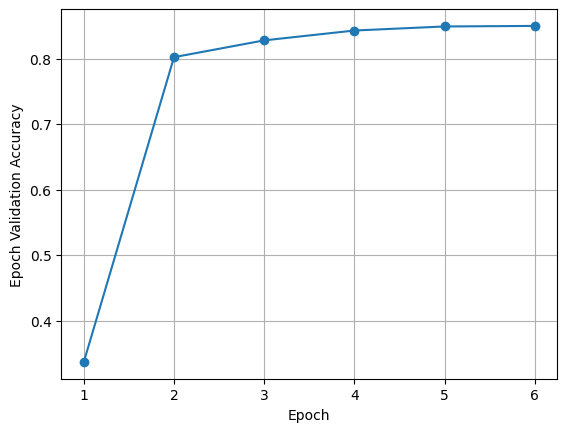

In [24]:
mca = agnews_model.val_metrics_tracker.compute_all()['MulticlassAccuracy']
plt.plot(range(1, len(mca)+1), mca, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Epoch Validation Accuracy')
plt.grid()

### Test Set Performance

In [25]:
trainer.test(model=agnews_model, dataloaders=dm.test_dataloader())
rslt = agnews_model.test_metrics_tracker.compute()

/Users/amasino/miniconda3/envs/pytorch-spacy/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 475/475 [00:04<00:00, 110.59it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.4869469702243805     │
└───────────────────────────┴───────────────────────────┘

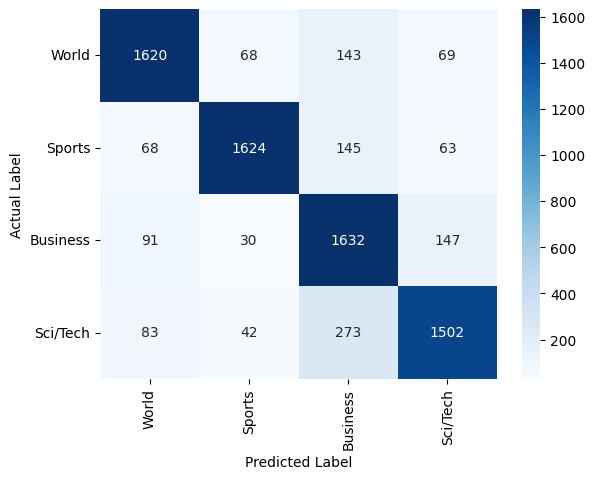

In [22]:
cmp = sns.heatmap(rslt['MulticlassConfusionMatrix'], annot=True, fmt='d', cmap='Blues')
cmp.set_xlabel('Predicted Label')
cmp.set_xticklabels(dm.class_name_map.values(), rotation=90)
cmp.set_yticklabels(dm.class_name_map.values(), rotation=0)
cmp.set_ylabel('Actual Label');

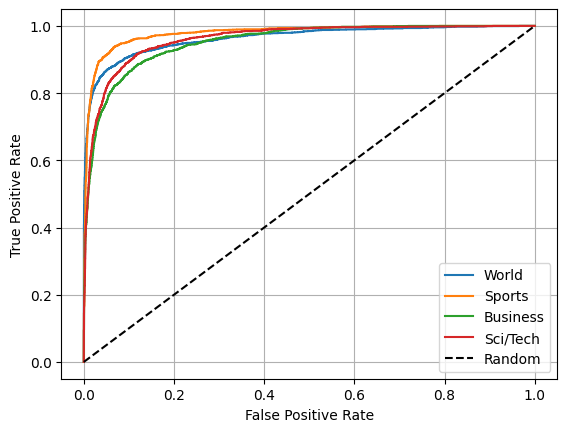

In [23]:
fpr, tpr, thresholds = rslt['MulticlassROC']
for i in range(len(dm.class_name_map)):
    plt.plot(fpr[i], tpr[i], label=dm.class_name_map[i])
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()